# Give Me Some Credit

## See [https://www.kaggle.com/c/GiveMeSomeCredit](https://www.kaggle.com/c/GiveMeSomeCredit)

- SeriousDlqin2yrs	Person experienced 90 days past due delinquency or worse 	Y/N
- RevolvingUtilizationOfUnsecuredLines	Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits	percentage
- age	Age of borrower in years	integer
- NumberOfTime30-59DaysPastDueNotWorse	Number of times borrower has been 30-59 days past due but no worse in the last 2 years.	integer
- DebtRatio	Monthly debt payments, alimony,living costs divided by monthy gross income	percentage
- MonthlyIncome	Monthly income	real
- NumberOfOpenCreditLinesAndLoans	Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards)	integer
- NumberOfTimes90DaysLate	Number of times borrower has been 90 days or more past due.	integer
- NumberRealEstateLoansOrLines	Number of mortgage and real estate loans including home equity lines of credit	integer
- NumberOfTime60-89DaysPastDueNotWorse	Number of times borrower has been 60-89 days past due but no worse in the last 2 years.	integer
- NumberOfDependents	Number of dependents in family excluding themselves (spouse, children etc.)	integer

## 载入相关包

In [1]:
library(tidyverse)
library(VIM)
library(caret)
library(pROC)
library(plotROC)

# require(randomForest)
# require(gbm)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.4
✔ tibble  1.3.4     ✔ dplyr   0.7.4
✔ tidyr   0.7.2     ✔ stringr 1.2.0
✔ readr   1.1.1     ✔ forcats 0.2.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: colorspace
Loading required package: grid
Loading required package: data.table

Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last

The following object is masked from ‘package:purrr’:

    transpose

VIM is ready to use. 
 Since version 4.0.0 the GUI is in its own package VIMGUI.

          Please use the package to use the new (and old) GUI.

Suggestions and bug-reports can be submitted at: https://github.com/alexkowa/VIM/issues

Attaching package: ‘VIM’

The following object is masked from ‘package:datasets’:

    sleep

## 载入数据

In [2]:
col_names <- c(
    'id', 'sd2y', 'ruul', 'age', 'nt3059dpdnw', 'dr',
    'mi', 'nocll', 'nt90dl', 'nrell', 'nt6089dpdnw', 'nd'
)

col_types <- cols(
    id = col_character(),
    sd2y = col_factor(levels = c(0, 1)),
    ruul = col_double(),
    age = col_integer(),
    nt3059dpdnw = col_integer(),
    dr = col_double(),
    mi = col_integer(),
    nocll = col_integer(),
    nt90dl = col_integer(),
    nrell = col_integer(),
    nt6089dpdnw = col_integer(),
    nd = col_integer()
)

cs_raw <- read_csv('../Data/cs-training.csv',
                  col_names = col_names, 
                  col_types = col_types,
                  skip = 1, na = 'NA')

## 数据探索性分析

In [3]:
summary(cs_raw)

      id            sd2y            ruul               age       
 Length:150000      0:139974   Min.   :    0.00   Min.   :  0.0  
 Class :character   1: 10026   1st Qu.:    0.03   1st Qu.: 41.0  
 Mode  :character              Median :    0.15   Median : 52.0  
                               Mean   :    6.05   Mean   : 52.3  
                               3rd Qu.:    0.56   3rd Qu.: 63.0  
                               Max.   :50708.00   Max.   :109.0  
                                                                 
  nt3059dpdnw           dr                 mi              nocll       
 Min.   : 0.000   Min.   :     0.0   Min.   :      0   Min.   : 0.000  
 1st Qu.: 0.000   1st Qu.:     0.2   1st Qu.:   3400   1st Qu.: 5.000  
 Median : 0.000   Median :     0.4   Median :   5400   Median : 8.000  
 Mean   : 0.421   Mean   :   353.0   Mean   :   6670   Mean   : 8.453  
 3rd Qu.: 0.000   3rd Qu.:     0.9   3rd Qu.:   8249   3rd Qu.:11.000  
 Max.   :98.000   Max.   :329664.0   Max

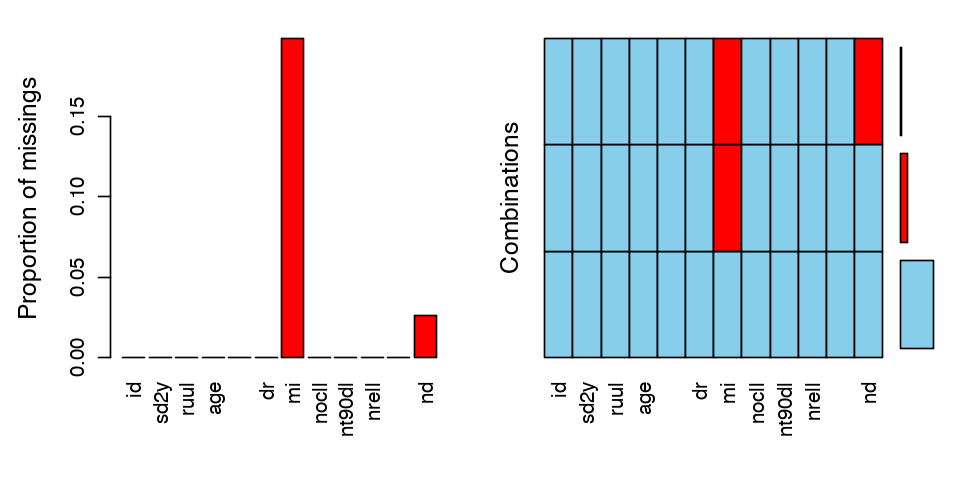

In [4]:
options(repr.plot.width=8, repr.plot.height=4)

aggr(cs_raw)

## 特征工程

In [5]:
pre_processing <- function(data) {
    # Number Of Dependents
    data$nd_unknown <- as.integer(is.na(data$nd))
    data$nd_zero <- as.integer(data$nd == 0 & !is.na(data$nd))
    data$nd[is.na(data$nd) | data$nd < 0] <- 0
    
    # Revolving Utilization Of Unsecured Lines
    data$ruul_zero <- as.integer(data$ruul == 0)
    data$ruul_weird <- as.integer(log(data$ruul) > 3)
    data$ruul_one <- as.integer(data$ruul == 1)
    data$ruul_gt_one <- as.integer(data$ruul > 1)
    data$ruul_09999999 <- as.integer(data$ruul == 0.9999999)
    data$ruul[log(data$ruul) > 3] <- 0
    data$ruul_log <- log(data$ruul)
    data$ruul_log[!is.finite(data$ruul_log)] <- 0
    data$ruul <- NULL
    
    # Age
    
    # Number Of Time 30-59 Days Past Due Not Worse
    data$nt3059dpdnw_96 <- as.integer(data$nt3059dpdnw == 96)
    data$nt3059dpdnw_98 <- as.integer(data$nt3059dpdnw == 98)
    data$nt3059dpdnw_zero <- as.integer(data$nt3059dpdnw == 0)
    data$nt3059dpdnw[data$nt3059dpdnw > 90] <- 0
    data$nt3059dpdnw_log <- log(data$nt3059dpdnw)
    data$nt3059dpdnw_log[!is.finite(data$nt3059dpdnw_log)] <- 0
    data$nt3059dpdnw <- NULL
    
    # Number Of Time 60-89 Days Past Due Not Worse
    data$nt6089dpdnw_96 <- as.integer(data$nt6089dpdnw == 96)
    data$nt6089dpdnw_98 <- as.integer(data$nt6089dpdnw == 98)
    data$nt6089dpdnw_zero <- as.integer(data$nt6089dpdnw == 0)
    data$nt6089dpdnw[data$nt6089dpdnw > 90] <- 0
    data$nt6089dpdnw_log <- log(data$nt6089dpdnw)
    data$nt6089dpdnw_log[!is.finite(data$nt6089dpdnw_log)] <- 0
    data$nt6089dpdnw <- NULL
    
    # Debt Ratio
    data$dr_zero <- as.integer(data$dr == 0)
    data$dr_log <- log(data$dr)
    data$dr_log[!is.finite(data$dr_log)] <- 0
    data$dr <- NULL
    
    # Monthly Income
    data$mi_unknown <- as.integer(is.na(data$mi))
    data$mi_zero <- as.integer(data$mi == 0 & !is.na(data$mi))
    data$mi[is.na(data$mi)] <- 0
    data$mi_one <- as.integer(data$mi == 1)
    data$mi_log <- log(data$mi)
    data$mi_log[!is.finite(data$mi_log)] <- 0
    data$mi_log_per_person <- data$mi_log - log1p(data$nd)
    data$mi <- NULL
    
    # Number Of Open Credit Lines And Loans
    data$nocll_zero <- as.integer(data$nocll == 0)
    data$nocll_log <- log(data$nocll)
    data$nocll_log[!is.finite(data$nocll_log)] <- 0
    data$nocll_log_per_person <- data$nocll_log - log1p(data$nd)
    data$nocll <- NULL
    
    # Number Of Real Estate Loans Or Lines
    data$nrell_zero <- as.integer(data$nrell == 0)
    data$nrell_log <- log(data$nrell)
    data$nrell_log[!is.finite(data$nrell_log)] <- 0
    data$nrell_log_per_person <- data$nrell_log - log1p(data$nd)
    data$nrell <- NULL
    
    # Number Of Times 90 Days Late
    data$nt90dl_zero <- as.integer(data$nt90dl == 0)
    data$nt90dl_log <- log(data$nt90dl)
    data$nt90dl_log[!is.finite(data$nt90dl_log)] <- 0
    data$nt90dl <- NULL
    
    data
}

cs <- pre_processing(cs_raw)

## 数据集划分

In [6]:
cs_sample_index <- createDataPartition(cs$sd2y, p = 0.1, list = F)
cs_sample <- cs[cs_sample_index, ]
cs_train_index <- createDataPartition(cs_sample$sd2y, p = 0.7, list = F)
cs_train <- cs_sample[cs_train_index, 2:35]
cs_test <- cs_sample[-cs_train_index, 2:35]

## 随机森林模型

In [7]:
cs_rf_ctrl <- trainControl(
    method = 'repeatedcv',
    number = 10,
    repeats = 5
)

cs_rf_model <- train(
    sd2y ~ .,
    data = cs_train,
    method = 'rf',
    # trControl = cs_rf_ctrl,
    metric = 'Kappa',
    ntree = 100,
    importance = T,
    verbose = F
)

randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:dplyr’:

    combine

The following object is masked from ‘package:ggplot2’:

    margin



### 特征重要性

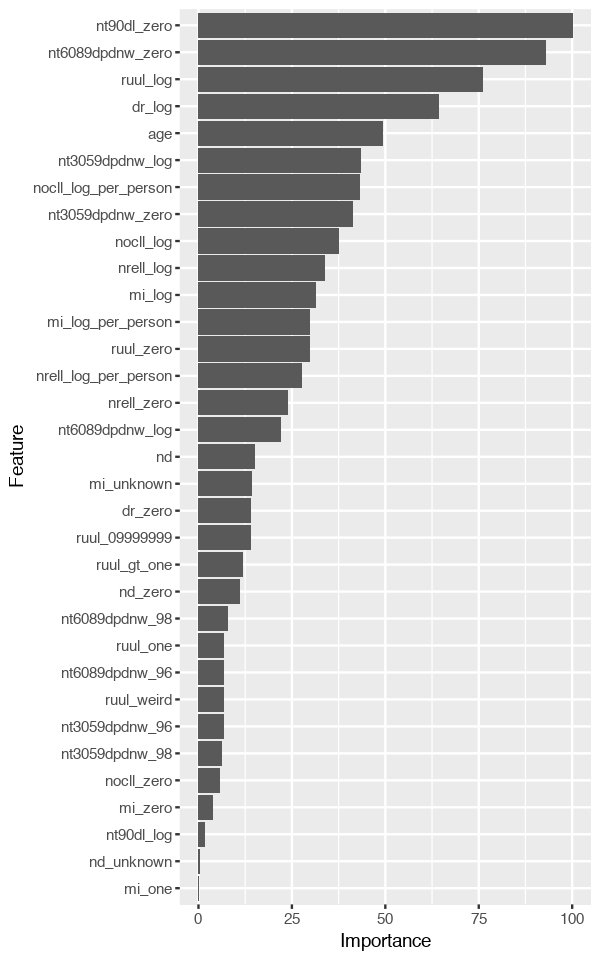

In [8]:
options(repr.plot.width=5, repr.plot.height=8)

ggplot(varImp(cs_rf_model))

### 模型性能

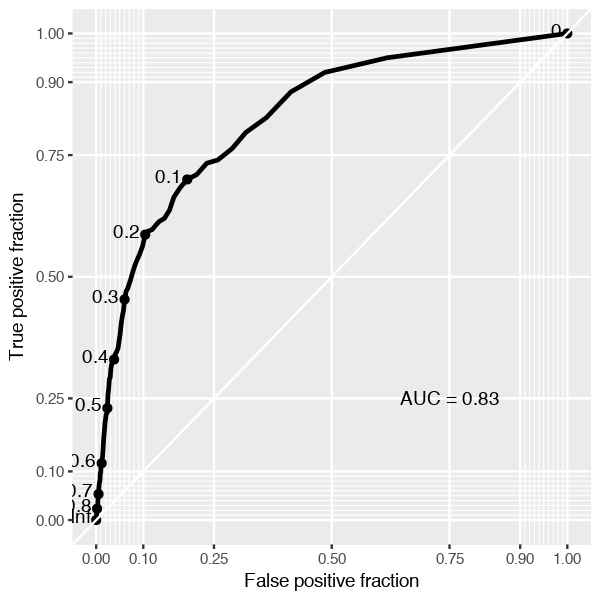

In [9]:
cs_rf_pred <- predict(cs_rf_model, cs_test, type = 'prob')

cs_rf_roc <- roc(cs_test$sd2y, cs_rf_pred[, 2])

cs_rf_roc_df <- data.frame(
    label = as.integer(as.character(cs_test$sd2y)),
    predicted = cs_rf_pred[, 2]
)

options(repr.plot.width=5, repr.plot.height=5)

cs_rf_roc_plot <- ggplot(cs_rf_roc_df, aes(d=label, m=predicted)) + 
    geom_roc() + style_roc(theme = theme_grey) + 
    annotate("text", x = .75, y = .25, 
             label = paste("AUC =", round(cs_rf_roc$auc, 2)))
print(cs_rf_roc_plot)

## GBM模型

In [10]:
options(warn=-1)

cs_gbm_ctrl <- trainControl(
    method = 'repeatedcv',
    number = 10,
    repeats = 5
)

cs_gbm_model <- train(
    sd2y ~ .,
    data = cs_train,
    method = 'gbm',
    # trControl = cs_rf_ctrl,
    metric = 'Kappa',
    verbose = F
)

options(warn=0)

Loading required package: survival

Attaching package: ‘survival’

The following object is masked from ‘package:caret’:

    cluster

Loading required package: splines
Loading required package: parallel
Loaded gbm 2.1.3
------------------------------------------------------------------------------
You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)
------------------------------------------------------------------------------

Attaching package: ‘plyr’

The following objects are masked from ‘package:dplyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following object is masked from ‘package:purrr’:

    compact



### 模型重要性

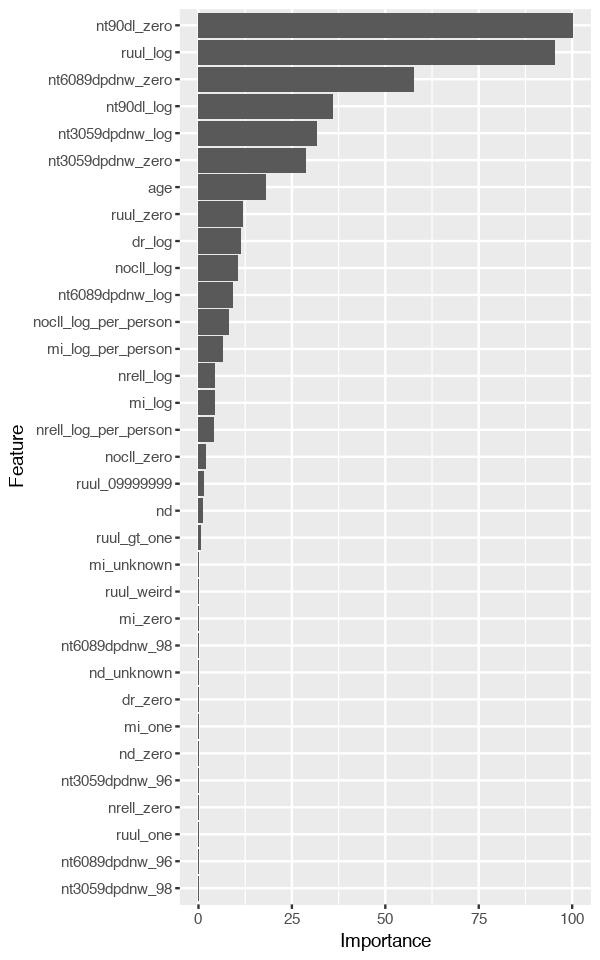

In [11]:
options(repr.plot.width=5, repr.plot.height=8)

ggplot(varImp(cs_gbm_model))

### 模型性能

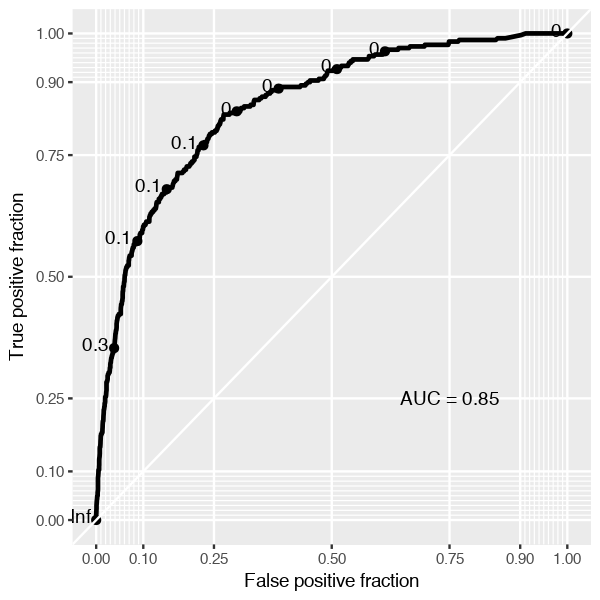

In [12]:
cs_gbm_pred <- predict(cs_gbm_model, cs_test, type = 'prob')

cs_gbm_roc <- roc(cs_test$sd2y, cs_gbm_pred[, 2])

cs_gbm_roc_df <- data.frame(
    label = as.integer(as.character(cs_test$sd2y)),
    predicted = cs_gbm_pred[, 2]
)

options(repr.plot.width=5, repr.plot.height=5)

cs_gbm_roc_plot <- ggplot(cs_gbm_roc_df, aes(d=label, m=predicted)) + 
    geom_roc() + style_roc(theme = theme_grey) + 
    annotate("text", x = .75, y = .25, 
             label = paste("AUC =", round(cs_gbm_roc$auc, 2)))
print(cs_gbm_roc_plot)

## 模型比较

In [13]:
cs_lr_model <- glm(
    sd2y ~ .,
    family = binomial(link = 'logit'),
    data = cs_train
)

cs_lr_pred <- predict(cs_lr_model, cs_test, type = 'response')

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
“prediction from a rank-deficient fit may be misleading”

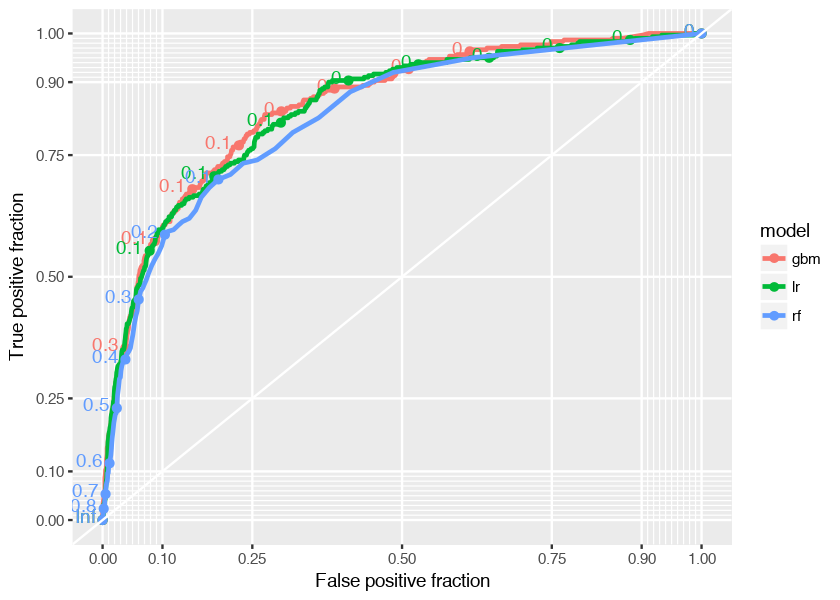

In [14]:
cs_roc_df <- data.frame(
    label = as.integer(as.character(cs_test$sd2y)),
    rf = cs_rf_pred[, 2],
    gbm = cs_gbm_pred[, 2],
    lr = cs_lr_pred
)

cs_rof_df_ <- gather(cs_roc_df, model, predicted, -label)

options(repr.plot.width=7, repr.plot.height=5)

cs_roc_plt <- ggplot(cs_rof_df_, aes(d=label, m=predicted, color=model)) + 
    geom_roc() + style_roc(theme = theme_grey)
print(cs_roc_plt)